# Representation Learning using Auto Encoders
In this notebook, we delve deeper into representation learning through autoencoders. Specifically, we will explore two autoencoder architectures: the denoising autoencoder and the contractive autoencoder. For each, we will compare the "standard version" (one trained with all the layers simultaneously) with the unsupervised layer-wise pretrained version.

To assess the quality of the auto-encoder, we will use the following tools:

- T-SNE for visualizing the manifold in 2 dimensions.
- Reconstruction error to measure the difference between the reconstructed image and the original one (on the test set).
- Classification accuracy (using only the encoder part of each autoencoder).

#### DISCLAIMER!
For the classification task, we will use a very simple model: the logistic regressor. It must be noted that due to the linearity of the model, it may not be the most suitable for classifying encoded representations, as they might lie in highly non-linear spaces. However, its use here is justified purely for comparison purposes. The main reason the representations might lie in highly non-linear spaces (and potentially be less linearly separable than the original MNIST space) is that undercomplete autoencoders naturally compress the space into a smaller dimensional one.

Some trails with overcomplete auto-encoders have been performed, but the differences in results were not relevant enough to be included in the analysis.

## Imports and versions

In [1]:
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

2024-05-17 10:43:32.809275: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 10:43:32.809427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 10:43:32.980876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# print("Keras version:", K.__version__)
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

Num GPUs Available:  2
GPU is available


## Methods

### Utilities

In [4]:
NOISE_FACTOR=0.5

def add_noise(data, noise_factor=NOISE_FACTOR):
    """
    Adds random noise to the input data.

    Parameters:
    - data: numpy array, input data to add noise to.
    - noise_factor: float, factor controlling the amount of noise to be added. Default is 0.5.

    Returns:
    - noised_data: numpy array, input data with added noise.
    """
    noised_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    noised_data = np.clip(noised_data, 0., 1.)
    return noised_data

def convergence(model, max_iter=100, n_img=10, conv=False):
    """
    Generates and displays denoised images using the given model through iterative gradient ascent.

    Parameters:
    - model: keras model, the autoencoder model used for denoising.
    - max_iter: int, maximum number of iterations for denoising. Default is 100.
    - n_img: int, number of images to display. Default is 10.
    - conv: bool, whether to use a converged image as input. Default is False.

    Returns:
    None
    """
    fig, axes = plt.subplots(1, n_img, figsize=(20, 2))

    for i in range(n_img):
        if conv:
            noise_image = np.random.normal(loc=0.5, scale=1., size=(1, 28, 28, 1))
        else:
            noise_image = np.random.normal(loc=0, scale=1, size=(1, 784))
        noise_image = np.clip(noise_image, 0., 1.)

        for _ in range(max_iter):
            noise_image = model.predict(noise_image, verbose=0)

        # Plot the denoised image
        ax = axes[i]
        ax.imshow(noise_image.reshape(28, 28), cmap='gray')
        ax.set_title(f"Image {i+1}")
        ax.axis('off')  # Hide axes ticks

    plt.show()

def show_tsne(x_sample, y_sample, encoder):
    """
    Generates and displays a t-SNE visualization of the encoded data.

    Parameters:
    - x_sample: numpy array, input data samples.
    - y_sample: numpy array, corresponding labels for the input data samples.
    - encoder: keras model, the encoder model used for encoding the data.

    Returns:
    None
    """
    encoded_data = encoder.predict(x_sample)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(encoded_data)

    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_sample, cmap='tab10', alpha=0.5)
    plt.colorbar()
    plt.title('t-SNE visualization of Autoencoder Encoded Data')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.show()

### Contractive-related

In [5]:
def frob_J_encoder_sigmoid(model, input):
    """
    Calculates the Frobenius norm of the Jacobian matrix of the encoder output with respect to the input data,
    in case of using a sigmoid activation function.

    Parameters:
    - model: The encoder model.
    - input: The input data.

    Returns:
    - The Frobenius norm of the Jacobian matrix.
    """
    f_enc = model(input)
    weights = tf.transpose(model.layers[-1].weights[0])
    sum_weights_squared = tf.reduce_sum(weights**2, axis=1)
    return tf.reduce_sum((f_enc * (1 - f_enc))**2 * sum_weights_squared)

def frob_J_encoder_relu(model, input):
    """
    Calculates the Frobenius norm of the Jacobian matrix of the encoder output with respect to the input data,
    in case of using a relu activation function.

    Parameters:
    - model: The encoder model.
    - input: The input data.

    Returns:
    - The Frobenius norm of the Jacobian matrix.
    """
    f_enc = model(input)
    weights = tf.transpose(model.layers[-1].weights[0])
    relu_prime = tf.cast(f_enc > 0, dtype=tf.float32)
    sum_weights_squared = tf.reduce_sum(weights**2, axis=1)
    return tf.reduce_sum(relu_prime**2 * sum_weights_squared)


def frob_J_encoder(model, input_data):
    """
    Calculates the Frobenius norm of the Jacobian matrix of the encoder output with respect to the input data.

    Parameters:
    - model: The encoder model.
    - input_data: The input data.

    Returns:
    - The Frobenius norm of the Jacobian matrix.
    """
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        f_enc = model(input_data)

    J = tape.jacobian(f_enc, input_data)
    return tf.norm(tf.reshape(J, (-1,)), ord='euclidean')

def contractive_loss(encoder, act='sigmoid', lam=1e-4):
    """
    Calculates the contractive loss for an autoencoder model.

    Parameters:
    - encoder: The encoder model.
    - sigmoid_flag: A flag indicating whether to use sigmoid activation in the contractive loss calculation.
    - lam: The regularization parameter.

    Returns:
    - The contractive loss function.
    """
    def loss(y_true, y_pred):
        mse = K.backend.mean(K.backend.square(y_true - y_pred), axis=-1)
        if act == 'sigmoid':
            return mse + lam * frob_J_encoder_sigmoid(encoder, y_true)
        elif act == 'relu':
            return mse + lam * frob_J_encoder_relu(encoder, y_true)
        else:
            return mse + lam * frob_J_encoder(encoder, y_true)
    return loss

### Architecture-related

In [6]:

def log_reg(train_images, train_labels, test_images, test_labels):
    """
    Logistic regression classifier.

    Args:
        train_images (numpy.ndarray): Training images.
        train_labels (numpy.ndarray): Training labels.
        test_images (numpy.ndarray): Test images.
        test_labels (numpy.ndarray): Test labels.

    Returns:
        tuple: Test loss and test accuracy.
    """
    # set up classifier model
    classifier_input = K.layers.Input(shape=(train_images.shape[1],))
    classifier_output = K.layers.Dense(10, activation='softmax')(classifier_input)
    classifier = K.Model(classifier_input, classifier_output)
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # early stopping
    early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)

    # training the classifier
    classifier.fit(train_images, train_labels, epochs=50, batch_size=128, validation_split=0.2, verbose=0, callbacks=[early_stopping])

    # classifier's evaluation
    test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
    print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')
    return test_loss, test_accuracy


def create_autoencoder(input_dim, hidden_dim, hidden_act='relu', cae_flag=False):
    """
    Create an autoencoder model.

    Args:
        input_dim (int): Input dimension.
        hidden_dim (int): Hidden dimension.
        hidden_act (str, optional): Activation function for hidden layer. Defaults to 'relu'.
        cae_flag (bool, optional): Flag indicating whether it is a contractive autoencoder. Defaults to False.

    Returns:
        tensorflow.keras.Model: Autoencoder model.
    """
    loss = 'mean_squared_error'
    input_img = K.layers.Input(shape=(input_dim,))
    encoded = K.layers.Dense(hidden_dim, activation=hidden_act)(input_img)
    decoded = K.layers.Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = K.Model(input_img, decoded)
    encoder = K.Model(input_img, encoded)
    if cae_flag:
        loss = contractive_loss(encoder, act='sigmoid')
    autoencoder.compile(optimizer='adam', loss=loss)
    return autoencoder


def train_autoencoder(autoencoder, x_train_noisy, x_train, epochs=50, batch_size=256):
    """
    Train an autoencoder model.

    Args:
        autoencoder (tensorflow.keras.Model): Autoencoder model.
        x_train_noisy (numpy.ndarray): Noisy training data.
        x_train (numpy.ndarray): Clean training data.
        epochs (int, optional): Number of epochs. Defaults to 50.
        batch_size (int, optional): Batch size. Defaults to 256.

    Returns:
        tensorflow.keras.callbacks.History: Training history.
    """
    early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
    history = autoencoder.fit(x_train_noisy, x_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    return history


def encode_data(encoder, data):
    """
    Encode data using an encoder model.

    Args:
        encoder (tensorflow.keras.Model): Encoder model.
        data (numpy.ndarray): Data to be encoded.

    Returns:
        numpy.ndarray: Encoded data.
    """
    return encoder.predict(data, verbose=0)


def build_stacked_autoencoder(input_dim, hidden_dims, autoencoders, cae_flag=False):
    """
    Build a stacked autoencoder model.

    Args:
        input_dim (int): Input dimension.
        hidden_dims (list): List of hidden dimensions.
        autoencoders (list): List of autoencoder models.
        cae_flag (bool, optional): Flag indicating whether it is a contractive autoencoder. Defaults to False.

    Returns:
        tuple: Stacked autoencoder model and encoder model.
    """
    loss='mean_squared_error'
    input_img = K.layers.Input(shape=(input_dim,))
    x = input_img
    encoders = []
    decoders = []

    # Build the encoder part
    for autoencoder in autoencoders:
        enc = autoencoder.layers[1](x)
        encoders.append(enc)
        x = enc

    # Build the decoder part in reverse order
    for autoencoder in reversed(autoencoders):
        dec = autoencoder.layers[2](x)
        decoders.insert(0, dec)
        x = dec

    # Final autoencoder model
    autoencoder = K.Model(input_img, decoders[0])
    encoder = K.Model(input_img, encoders[-1])
    if cae_flag:
        loss = contractive_loss(encoder, act='sigmoid')

    autoencoder.compile(optimizer='adam', loss=loss)
    return autoencoder, encoder


def gulp(x_train, input_dim, hidden_dims, x_train_noisy=None, noise_factor=NOISE_FACTOR, hidden_act='relu', cae_flag=False, epochs=50, batch_size=256):
    """
    Train a stacked autoencoder model.

    Args:
        x_train (numpy.ndarray): Training data.
        input_dim (int): Input dimension.
        hidden_dims (list): List of hidden dimensions.
        x_train_noisy (numpy.ndarray, optional): Noisy training data. Defaults to None.
        noise_factor (float, optional): Noise factor. Defaults to NOISE_FACTOR.
        hidden_act (str, optional): Activation function for hidden layers. Defaults to 'relu'.
        cae_flag (bool, optional): Flag indicating whether it is a contractive autoencoder. Defaults to False.
        epochs (int, optional): Number of epochs. Defaults to 50.
        batch_size (int, optional): Batch size. Defaults to 256.

    Returns:
        tuple: Training time, training history, stacked autoencoder model, and encoder model.
    """
    og_input_dim = input_dim
    autoencoders = []
    input_data = x_train
    n_autoencoders = len(hidden_dims)

    if x_train_noisy is not None:
        encoded_data = x_train_noisy
    else:
        encoded_data = input_data

    start_time = time.time()

    for i in range(n_autoencoders):
        autoencoder = create_autoencoder(input_dim, hidden_dims[i], hidden_act=hidden_act, cae_flag=cae_flag)
        if x_train_noisy is not None:
            history = train_autoencoder(autoencoder, encoded_data, input_data, epochs, batch_size)
        else:
            history = train_autoencoder(autoencoder, encoded_data, encoded_data, epochs, batch_size)
        autoencoders.append(autoencoder)

        # Get the encoder part of the trained autoencoder
        encoder = K.Model(autoencoder.input, autoencoder.layers[1].output)
        input_data = encode_data(encoder, encoded_data)

        # Add noise if not the last autoencoder
        if i < n_autoencoders - 1 and x_train_noisy is not None:
            encoded_data = add_noise(input_data, noise_factor)
        elif x_train_noisy is None:
            encoded_data = input_data

        # Update input_dim for the next autoencoder
        input_dim = hidden_dims[i]

    autoencoder, encoder = build_stacked_autoencoder(og_input_dim, hidden_dims, autoencoders, cae_flag=cae_flag)
    training_time = time.time() - start_time

    return training_time, history, autoencoder, encoder

# Denoising Auto Encoder
In the following section, we explore Denoising Autoencoders (DAEs) as a method to learn useful representations of the MNIST dataset.

First, we will train a two-layer autoencoder with small dimensions, training all layers simultaneously. Next, we will implement Greedy Unsupervised Layerwise Pretraining. This method involves training the same two layers used previously, but one at a time. Specifically, we will train each layer to predict the noised data from the preceding layer (with the first layer receiving the input data). Finally, we will fine-tune the autoencoder to assess any potential improvements

### Data preprocessing

In [7]:
(train_images, og_train_labels), (test_images, og_test_labels) = mnist.load_data()

# reshape images to 1D
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 784))
test_images = test_images.reshape((len(test_images), 784))

# add noise to images
x_train_noisy = add_noise(train_images)
x_test_noisy = add_noise(test_images)

train_labels = K.utils.to_categorical(og_train_labels, 10)
test_labels = K.utils.to_categorical(og_test_labels, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
df_result = pd.DataFrame(columns=['Model', 'Training Loss', 'Validation Loss', 'Test Loss', 'Test Accuracy', 'Reconstruction Error', 'Training Time'])

### 2-layers Auto-Encoder

In [9]:
# setting up the model
input_img = K.layers.Input(shape=(784,))
# encoder
encoded = K.layers.Dense(256, activation='relu')(input_img)
encoded = K.layers.Dense(128, activation='relu')(encoded)
# decoder
decoded = K.layers.Dense(256, activation='relu')(encoded)
decoded = K.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = K.Model(input_img, decoded)
encoder = K.Model(input_img, encoded)

start_time = time.time()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# early stopping
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)

# autoencoder's training
history = autoencoder.fit(x_train_noisy, train_images, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=0, callbacks=[early_stopping])
training_time = time.time() - start_time

I0000 00:00:1715942632.482476     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715942632.496350     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715942633.742024     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 33.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


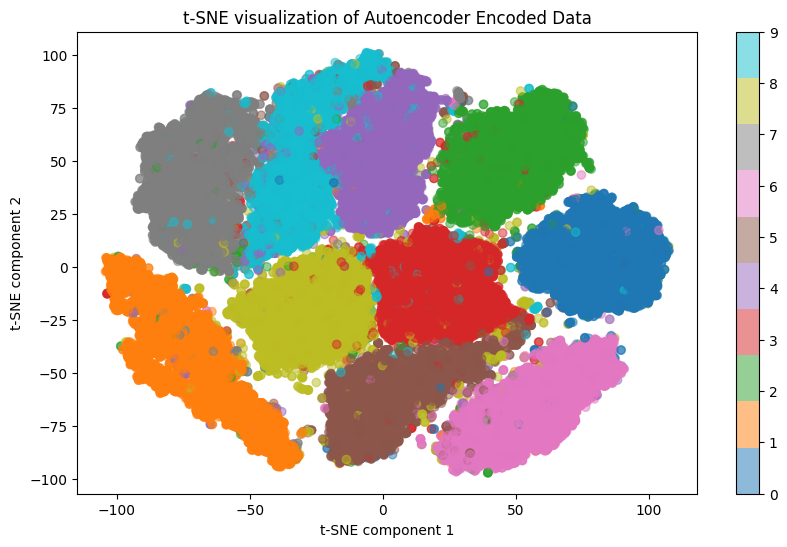

In [10]:
show_tsne(train_images, og_train_labels, encoder)

the representation seems to be quite solid, showing kind of a strong separation between digits.

#### Classification score, reconstruction error and manifold convergence

In [11]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(x_train_noisy, verbose=0)
encoded_test_images = encoder.predict(x_test_noisy, verbose=0)

test_loss, test_accuracy = log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8396 - loss: 0.4995
Test accuracy: 0.8614000082015991, Test loss: 0.4306946396827698


In [12]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(x_test_noisy, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

W0000 00:00:1715943074.027060     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715943074.574697     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Reconstruction error: 0.014014007523655891


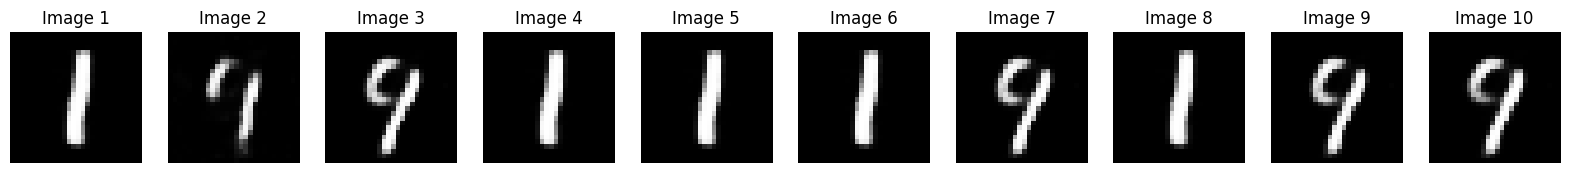

In [13]:
convergence(autoencoder)

and as we can appreciate, the random noise imaage converges into the same two digits (which is quite expected behaviour).

In [14]:
result_data = {
    'Model': '2 layers (256, 128) DAE',
    'Training Loss': history.history['loss'][-1],
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy,
    'Reconstruction Error': reconstruction_error,
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

/tmp/ipykernel_34/3240950316.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, new_row], ignore_index=True)


### Greedy Unsupervised Layerwise Pretraining
As anticipated above, we are now implementing the GULP strategy to train deep autoencoders (each one composed of a single layer). In this case, given the simpplicity of the dataset we are going to use just two autoencoders (one with a layer of 256 units and one with a layer of 128, in order to match the structure of the previous built autoencoder).

#### Pre-training

In [15]:
training_time, history, autoencoder, encoder = gulp(train_images, 784, [256, 128], x_train_noisy)

W0000 00:00:1715943129.487144     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715943130.211171     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 39.
Restoring model weights from the end of the best epoch: 50.


##### Classification score, reconstruction error and manifold convergence

In [16]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(x_train_noisy, verbose=0)
encoded_test_images = encoder.predict(x_test_noisy, verbose=0)

test_loss, test_accuracy = log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8258 - loss: 0.5518
Test accuracy: 0.8531000018119812, Test loss: 0.47184228897094727


In [17]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(x_test_noisy, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

W0000 00:00:1715943196.017178     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Reconstruction error: 0.05530685931444168


W0000 00:00:1715943196.480378     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


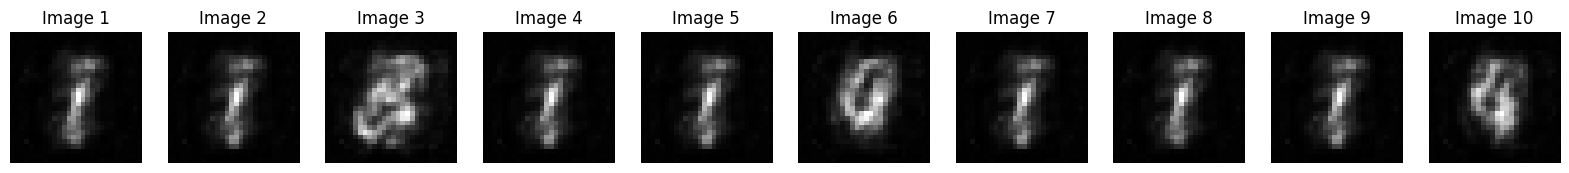

In [18]:
convergence(autoencoder)

The pre-training did not end up with a significant representation of the data, though as we can see from the image, it seems to be getting a grasp on where most digits are located –i.e. in the center of the image. Also, if we really squint our eyes, we can get a preview of what the autoencoder is trying to recreate (which it seems to be a 9).

To improve the perfomance, we are now fine-tuning the model, precisely we are letting the model train for some other epochs until it starts to overfit (using early stopping to prevent it). Notice that the weights do not reset, rather they are set from the pre-training.

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


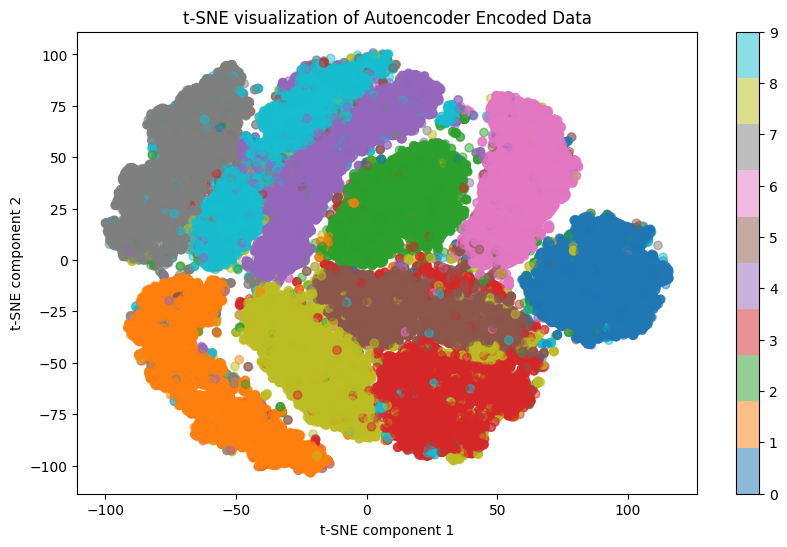

In [19]:
show_tsne(train_images, og_train_labels, encoder)

Although the reconstructed images did not converge into meaningful results, we can observe an interesting separation between digits. This suggests that the encoder may have learned a powerful representation, but the decoder has not yet fully captured the necessary patterns for accurate reconstruction.

In [20]:
result_data = {
    'Model': 'GULP 2 layers (256, 128) DAE (pre-training)',
    'Training Loss': history.history['loss'][-1],
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy,
    'Reconstruction Error': reconstruction_error,
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

#### Fine-tuning

In [21]:
# fine-tuning the full autoencoder
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
start_time = time.time()
history = autoencoder.fit(x_train_noisy, train_images, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)
training_time = time.time() - start_time

W0000 00:00:1715943648.742262     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715943649.788321     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 42.


##### Classification score, reconstruction error and manifold convergence

In [22]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(x_train_noisy, verbose=0)
encoded_test_images = encoder.predict(x_test_noisy, verbose=0)

test_loss, test_accuracy = log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8420 - loss: 0.4743
Test accuracy: 0.8615999817848206, Test loss: 0.4155028462409973


In [23]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(x_test_noisy, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction error: 0.01635509356856346


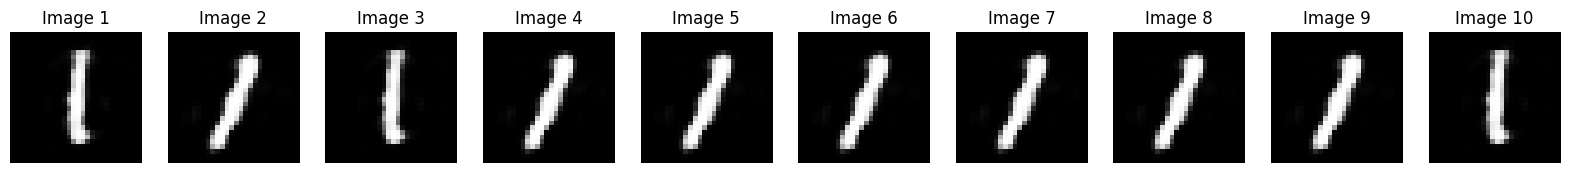

In [24]:
convergence(autoencoder)

Slighlty different results from the previous model. Here the digits converge slower into a more variagated set (digits 1, 6, 8 and 9 seem to be involved).

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


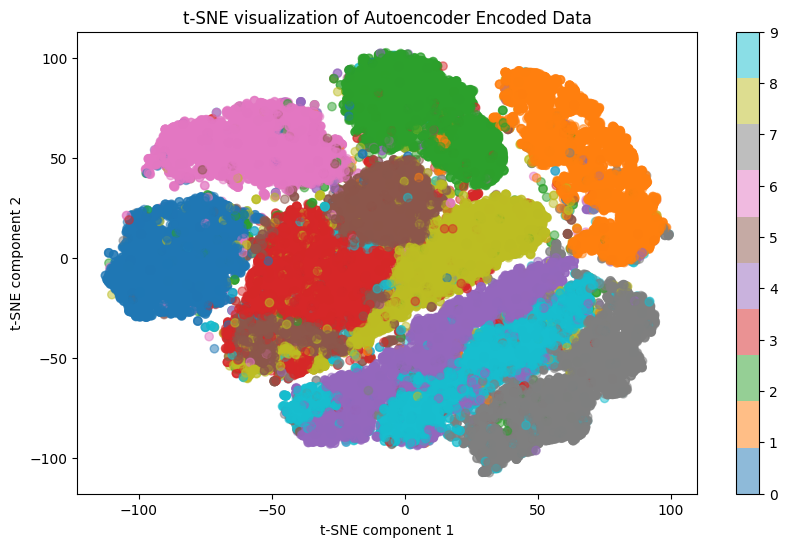

In [25]:
show_tsne(train_images, og_train_labels, encoder)

Also, the space seems to be slightly less well-separated in comparison to the first model.

In [26]:
result_data = {
    'Model': 'GULP 2 layers (256, 128) DAE (fine-tuning)',
    'Training Loss': history.history['loss'][-1],
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy,
    'Reconstruction Error': reconstruction_error,
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

### Using a U-Shaped CNN as encoder-decoder structure
Since we are dealing with images, we will now see whether using a U-Shaped CNN gives us any conspicuous advantage. We will restrict ourselves to just explore a simple structure of two convolutions/deconvolutions (where we will use maxpooling to downsample and a strided deconvolution to upsample).

In [27]:
(train_images_2D, _), (test_images_2D, _) = mnist.load_data()

train_images_2D = train_images_2D.astype('float32') / 255.
test_images_2D = test_images_2D.astype('float32') / 255.

train_images_2D = np.reshape(train_images_2D, (len(train_images_2D), 28, 28, 1))
test_images_2D = np.reshape(test_images_2D, (len(test_images_2D), 28, 28, 1))

x_train_noisy_2D = add_noise(train_images_2D)
x_test_noisy_2D = add_noise(test_images_2D)

In [28]:
input_img = K.layers.Input(shape=(28, 28, 1))
# encoder
x = K.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = K.layers.MaxPooling2D((2, 2), padding='same')(x)
x = K.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = K.layers.MaxPooling2D((2, 2), padding='same')(x)

# decoder
x = K.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = K.layers.UpSampling2D((2, 2))(x)
x = K.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = K.layers.UpSampling2D((2, 2))(x)
decoded = K.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = K.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
start_time = time.time()
history = autoencoder.fit(x_train_noisy_2D, train_images_2D, epochs=50, batch_size=128, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)
training_time = time.time() - start_time

Restoring model weights from the end of the best epoch: 46.


##### Classification score, reconstruction error and manifold convergence

In [29]:
# extracting the encoder part from the trained autoencoder
autoencoder_input = K.layers.Input(shape=(28, 28, 1))
x = autoencoder.layers[1](autoencoder_input)  # first Conv2D layer
x = autoencoder.layers[2](x)  # first MaxPooling2D layer
x = autoencoder.layers[3](x)  # second Conv2D layer
encoded_output = autoencoder.layers[4](x)  # second MaxPooling2D layer

# logistic regressor
flatten = K.layers.Flatten()(encoded_output)
dense = K.layers.Dense(128, activation='relu')(flatten)
classifier_output = K.layers.Dense(10, activation='softmax')(dense)
classifier_model = K.Model(autoencoder_input, classifier_output)
encoder = K.Model(autoencoder_input, flatten)

classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier_model.fit(x_train_noisy_2D, train_labels, epochs=30, batch_size=256, validation_split=0.2, verbose=0)

test_loss, test_accuracy = classifier_model.evaluate(x_test_noisy_2D, test_labels, verbose=0)
print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')

W0000 00:00:1715944239.199919     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715944240.954508     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715944241.578278     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715944242.542463     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test accuracy: 0.9671000242233276, Test loss: 0.21580417454242706


In [30]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(x_test_noisy_2D, verbose=0), test_images_2D).numpy()
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction error: 0.02257171832025051


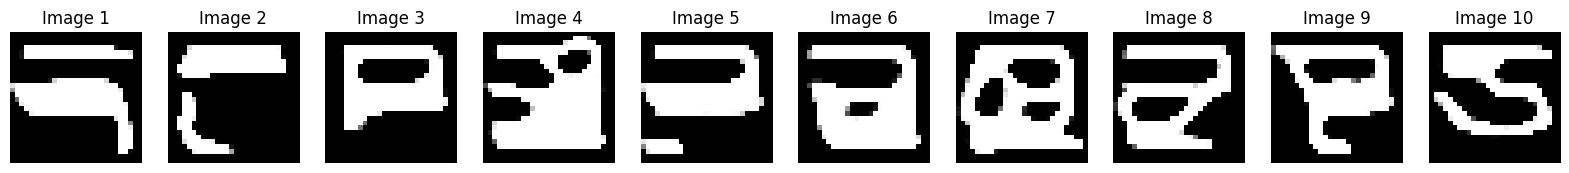

In [31]:
convergence(autoencoder, conv=True)

The accuracy surely gets better than the previous models, but the reconstructions are the weirdest looking ones so far.

In [32]:
result_data = {
    'Model': 'CNN 2 conv_layers DAE',
    'Training Loss': history.history['loss'][-1],
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy,
    'Reconstruction Error': reconstruction_error,
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


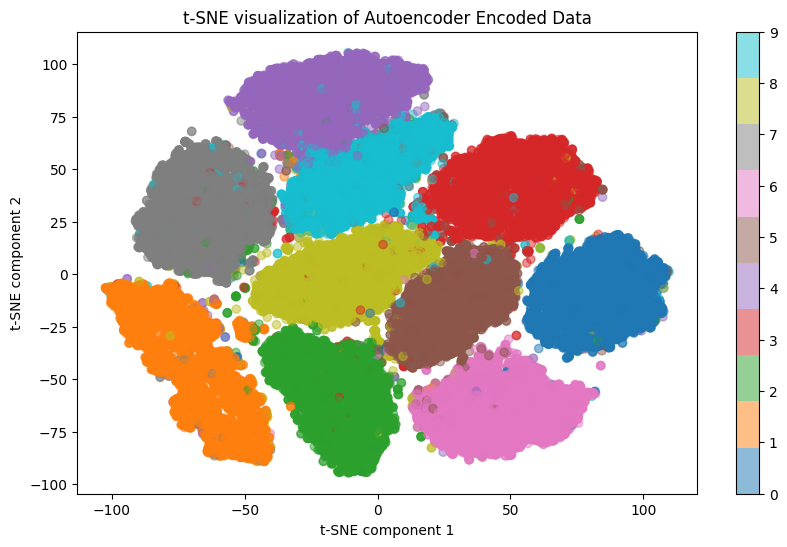

In [33]:
show_tsne(train_images_2D, og_train_labels, encoder)

##### Some notes on the CNN autoencoder's implementation
The chosen structure is a simple one, consisting of 2 convolutional layers and 2 deconvolutional layers, due to the 28x28 pixel size of the images. The binary cross-entropy loss function was necessary to ensure a stronger attraction basin for the minimum. Trials with mean squared error as the loss function showed that the model was unable to learn any meaningful representation.

# Contractive Auto Encoder
Until now, we have focused on using a denoising process for our training.

Contractive Autoencoders (CAEs) function similarly to Denoising Autoencoders (DAEs) but with a key difference: CAEs specifically penalize the derivative of the hidden representation with respect to the input. This means CAEs aim to minimize how much the internal representation changes in response to small changes in the input, enhancing the stability and robustness of the features. In contrast, DAEs focus on recovering an accurate, denoised version of the input from a deliberately corrupted version, encouraging the model to learn the more stable, structural characteristics of the data rather than the noise.

We'll follow the same approach as before, comparing an autoencoder with 2 layers trained together with the unsupervised pretrained version.

Let's have a brief discussion on the implementation of the contractive loss penalty term.
The objective for a Contractive Autoencoder (CAE) is to minimize a loss function that includes both the reconstruction loss (which measures the difference between the original sample and its reconstruction, e.g. mean squared error) and a contractive penalty term. This penalty term penalizes high variations in the representation manifold by encouraging the hidden representation to be less sensitive to small changes in the input.
All of this is represented by the following equation:

\begin{align}
    \mathcal{J}_{CAE}(\theta) = \sum_i^m L(x^{(i)}, g_\theta(f_\theta(x^{(i)})) + \lambda \left\|\frac{\partial f_\theta(x^{(i)})}{\partial x^{(i)}}\right\|^2_F,
\end{align}
where $g_\theta$ and $f_\theta$ are the decoder and encoder function respectively, and $\left\|\frac{\partial f_\theta(x^{(i)})}{\partial x^{(i)}}\right\|^2_F$ is the Frobenius norm of the encoder's Jacobian w.r.t. input $x^{(i)}$.

Notice however that, if dealing with deep Contractive Auto Encoders, the computation of this penalty term becomes quite intensive, since the partial derivatives must be taken considering the composition of functions (the layers in the network).

For this reason, altough implemented, we are not going to use the $\texttt{frob\_J\_encoder}$ function, since it implements the computation of the Jacobian through the auto differentiating method from Tensorflow. Instead we are going to use a simplified version, one that takes account for the use of the sigmoid function as activation.

Given the sigmoid as activation function the computation of the Jacobian becomes indeed pretty straightforward:

\begin{align}
    J_j(x) &= f_{\theta}(x)_j (1 - f_{\theta}(x)_j) W_j \\
    \left\|J(x)\right\|^2_F &= \sum_j \left( f_{\theta}(x)_j (1 - f_{\theta}(x)_j) \right)^2 \left\| W_j \right\|^2
\end{align}

where $J = \frac{\partial f_\theta(x)}{\partial x}$ is the Jacobian of the encoder on $x$ and the subscript $j$ represents the $j$-th entry of the Jacobian.

This clearly makes the computation way more easy since we don't even have to treat $J$ as a matrix (we could assume to have a diagonal matrix, that we do not need do create in any case, to which we multiply the norm-2 of the weight matrix).

#### DISCLAIMER!
In practice, using the GradientTape to compute the Jacobian wasn't feasible on 30GB of RAM for a 2 layer DAE, for this reason we needed a more low-level approach.

### Data preprocessing

In [34]:
(train_images, og_train_labels), (test_images, og_test_labels) = mnist.load_data()

# reshape images to 1D
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 784))
test_images = test_images.reshape((len(test_images), 784))

train_labels = K.utils.to_categorical(og_train_labels, 10)
test_labels = K.utils.to_categorical(og_test_labels, 10)

### 2-layers Auto-Encoder (Sigmoid activation)

In [35]:
# setting up the model
input_img = K.layers.Input(shape=(784,))
encoded = K.layers.Dense(256, activation='sigmoid')(input_img)
encoded = K.layers.Dense(128, activation='sigmoid')(encoded)
decoded = K.layers.Dense(256, activation='sigmoid')(encoded)
decoded = K.layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = K.Model(input_img, decoded)
encoder = K.Model(input_img, encoded)

custom_loss = contractive_loss(encoder, act='sigmoid')
autoencoder.compile(optimizer='adam', loss=custom_loss)

# autoencoder's training
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
start_time = time.time()
history = autoencoder.fit(train_images, train_images, epochs=30, batch_size=256, shuffle=True, validation_split=0.2, verbose=0, callbacks=[early_stopping])
training_time = time.time() - start_time

W0000 00:00:1715944955.604271     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715944956.686212     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715944957.290765     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715944957.740781     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Restoring model weights from the end of the best epoch: 30.


#### Classification score, reconstruction error and manifold convergence

In [36]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(train_images, verbose=0)
encoded_test_images = encoder.predict(test_images, verbose=0)

test_loss, test_accuracy = log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Restoring model weights from the end of the best epoch: 49.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7987 - loss: 0.6169
Test accuracy: 0.8213000297546387, Test loss: 0.5593355894088745


In [37]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(test_images, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

W0000 00:00:1715945011.129353     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715945011.632794     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Reconstruction error: 0.03390609472990036


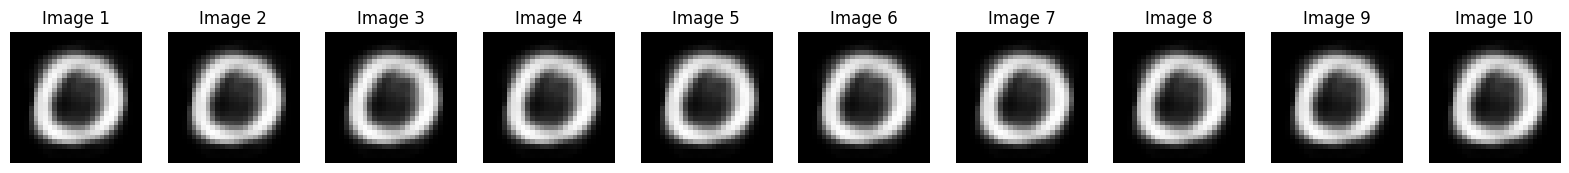

In [38]:
convergence(autoencoder)

Unlike what we have observed so far, the reconstructions do not seem to be very meaningful. This behavior may be due to the use of sigmoid activation in all layers, which compresses the outputs into a narrow range in a non-trivial manner. As a result, the decoder's task becomes more challenging since it receives a very squashed signal as input

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


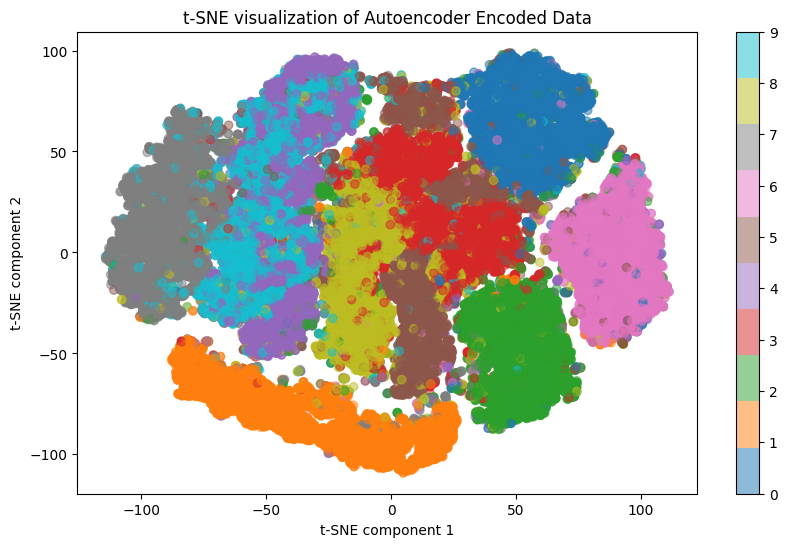

In [39]:
show_tsne(train_images, og_train_labels, encoder)

Looking at the manifold representation through T-SNE we see clear separation between all the clusters, thus showing that the encoder has indeed learnt a meaningful representation. This aligns with the hypothesis proposed above, for which the hardest part is that of the decoder function.

We might conclude that, altough not having a great reconstruction, the auto-encoder is actually doing its job. The hypothesis is further supported by the small reconstruction error obtained on the test set.

In [40]:
result_data = {
    'Model': '2 layers (256, 128) sigmoid CAE',
    'Training Loss': history.history['loss'][-1],
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy,
    'Reconstruction Error': reconstruction_error,
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

### 2-layers Auto-Encoder (ReLU activation)

In [41]:
# setting up the model
input_img = K.layers.Input(shape=(784,))
encoded = K.layers.Dense(256, activation='relu')(input_img)
encoded = K.layers.Dense(128, activation='relu')(encoded)
decoded = K.layers.Dense(256, activation='relu')(encoded)
decoded = K.layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = K.Model(input_img, decoded)
encoder = K.Model(input_img, encoded)

custom_loss = contractive_loss(encoder, act='relu')
autoencoder.compile(optimizer='adam', loss=custom_loss)

# autoencoder's training
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
start_time = time.time()
history = autoencoder.fit(train_images, train_images, epochs=30, batch_size=256, shuffle=True, validation_split=0.2, verbose=0, callbacks=[early_stopping])
training_time = time.time() - start_time

W0000 00:00:1715945416.333985     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715945417.373140     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715945417.907938     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715945418.233795     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Restoring model weights from the end of the best epoch: 29.


#### Classification score, reconstruction error and manifold convergence

In [42]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(train_images, verbose=0)
encoded_test_images = encoder.predict(test_images, verbose=0)

test_loss, test_accuracy = log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Restoring model weights from the end of the best epoch: 50.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9005 - loss: 0.3313
Test accuracy: 0.9146000146865845, Test loss: 0.2865419387817383


In [43]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(test_images, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

W0000 00:00:1715945471.386908     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Reconstruction error: 0.013202791102230549


W0000 00:00:1715945471.840939     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


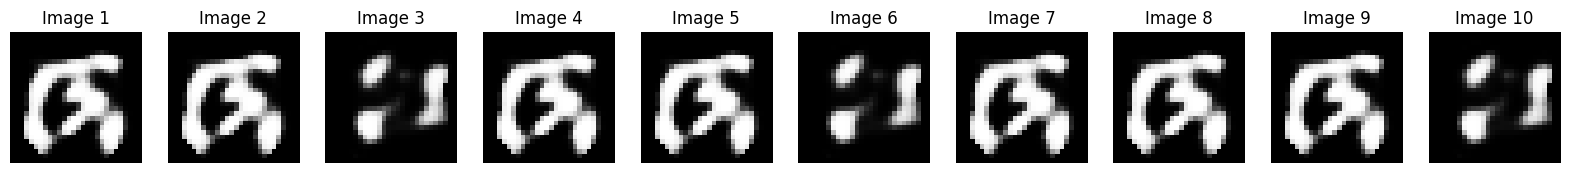

In [44]:
convergence(autoencoder)

Unlike what we have observed so far, the reconstructions do not seem to be very meaningful. This behavior may be due to the use of sigmoid activation in all layers, which compresses the outputs into a narrow range in a non-trivial manner. As a result, the decoder's task becomes more challenging since it receives a very squashed signal as input

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


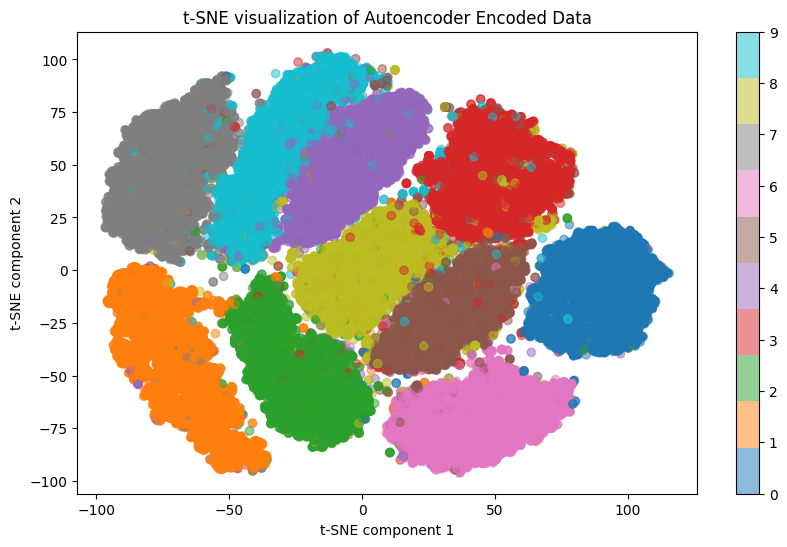

In [45]:
show_tsne(train_images, og_train_labels, encoder)

In [46]:
result_data = {
    'Model': '2 layers (256, 128) ReLU CAE',
    'Training Loss': history.history['loss'][-1],
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy,
    'Reconstruction Error': reconstruction_error,
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

### Greedy Unsupervised Layerwise Pretraining (just considering the sigmoid activation)

#### Pre-training

In [47]:
training_time, history, autoencoder, encoder = gulp(train_images, 784, [256, 128], hidden_act='sigmoid', cae_flag=True, epochs=20)

W0000 00:00:1715945919.911651     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715945920.753798     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715945921.233545     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715945921.591702     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Restoring model weights from the end of the best epoch: 20.
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


##### Classification score, reconstruction error and manifold convergence

In [48]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(train_images, verbose=0)
encoded_test_images = encoder.predict(test_images, verbose=0)

test_loss, test_accuracy = log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1009 - loss: 2.3010
Test accuracy: 0.10100000351667404, Test loss: 2.3021655082702637


In [49]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(test_images, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

W0000 00:00:1715945954.888687     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715945955.377408     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Reconstruction error: 0.06901933252811432


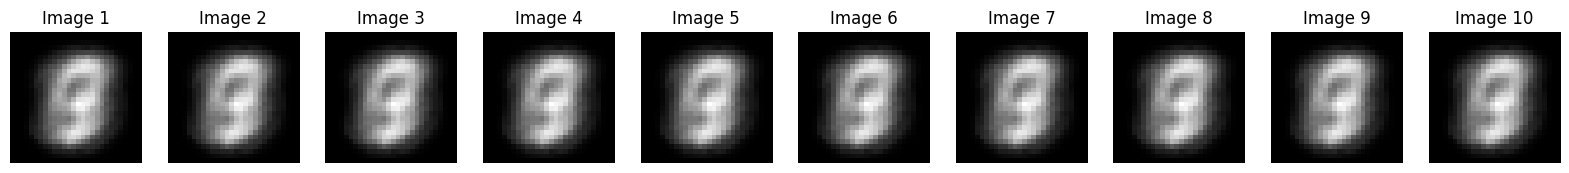

In [50]:
convergence(autoencoder, n_img=10)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


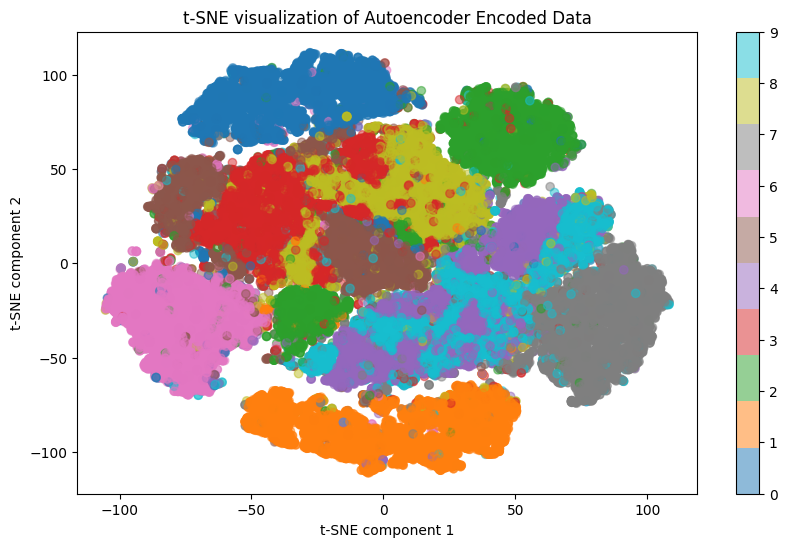

In [51]:
show_tsne(train_images, og_train_labels, encoder)

In [52]:
result_data = {
    'Model': 'GULP 2 layers (256, 128) CAE (pre-training)',
    'Training Loss': history.history['loss'][-1],
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy,
    'Reconstruction Error': reconstruction_error,
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

#### Fine-tuning

In [53]:
# fine-tuning the full autoencoder
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
start_time = time.time()
history = autoencoder.fit(train_images, train_images, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)
training_time = time.time() - start_time

W0000 00:00:1715946363.543936     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715946364.737736     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715946365.333947     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715946365.724636     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Restoring model weights from the end of the best epoch: 50.


##### Classification score, reconstruction error and manifold convergence

In [54]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(train_images, verbose=0)
encoded_test_images = encoder.predict(test_images, verbose=0)

test_loss, test_accuracy = log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Restoring model weights from the end of the best epoch: 50.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7884 - loss: 0.7083
Test accuracy: 0.8140000104904175, Test loss: 0.6584411859512329


In [55]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(test_images, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction error: 0.026754340156912804


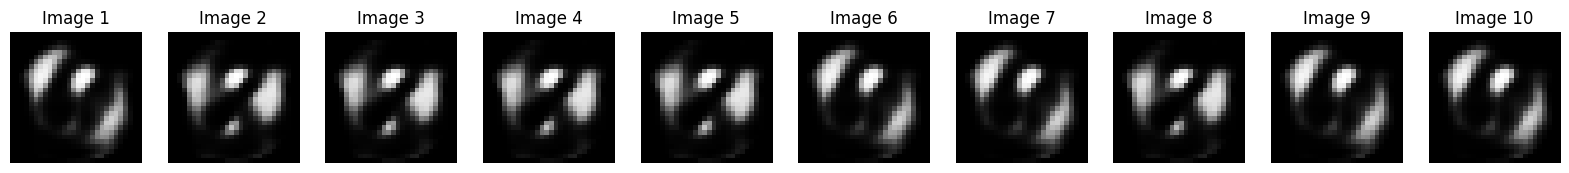

In [56]:
convergence(autoencoder)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


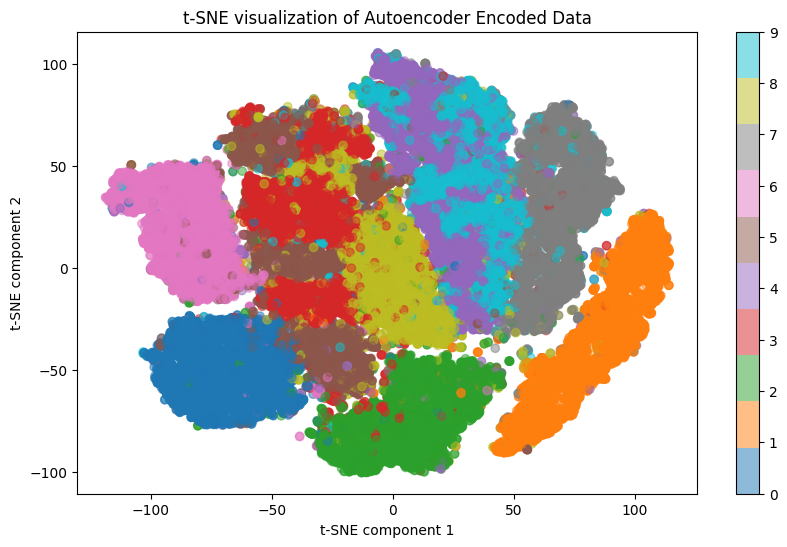

In [57]:
show_tsne(train_images, og_train_labels, encoder)

Quite similar results have been obtain on the GULP version.

In [58]:
result_data = {
    'Model': 'GULP 2 layers (256, 128) CAE (fine-tuning)',
    'Training Loss': history.history['loss'][-1],
    'Validation Loss': history.history['val_loss'][-1],
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy,
    'Reconstruction Error': reconstruction_error,
    'Training Time': training_time}

new_row = pd.DataFrame(result_data, index=[0])
df_result = pd.concat([df_result, new_row], ignore_index=True)

# Results and Analysis

In [59]:
df_result

,Model,Training Loss,Validation Loss,Test Loss,Test Accuracy,Reconstruction Error,Training Time
0,"2 layers (256, 128) DAE",0.012627,0.014281,0.430695,0.8614,0.014014,24.292017
1,"GULP 2 layers (256, 128) DAE (pre-training)",1.835211,1.829768,0.471842,0.8531,0.055307,50.714876
2,"GULP 2 layers (256, 128) DAE (fine-tuning)",0.012822,0.016634,0.415503,0.8616,0.016355,27.665117
3,CNN 2 conv_layers DAE,0.092954,0.094732,0.215804,0.9671,0.022572,92.776875
4,"2 layers (256, 128) sigmoid CAE",0.038964,0.038327,0.559336,0.8213,0.033906,18.906254
5,"2 layers (256, 128) ReLU CAE",0.015695,0.015675,0.286542,0.9146,0.013203,18.760131
6,"GULP 2 layers (256, 128) CAE (pre-training)",0.002210,0.002194,2.302166,0.1010,0.069019,25.220537
7,"GULP 2 layers (256, 128) CAE (fine-tuning)",0.028850,0.028870,0.658441,0.8140,0.026754,31.772032


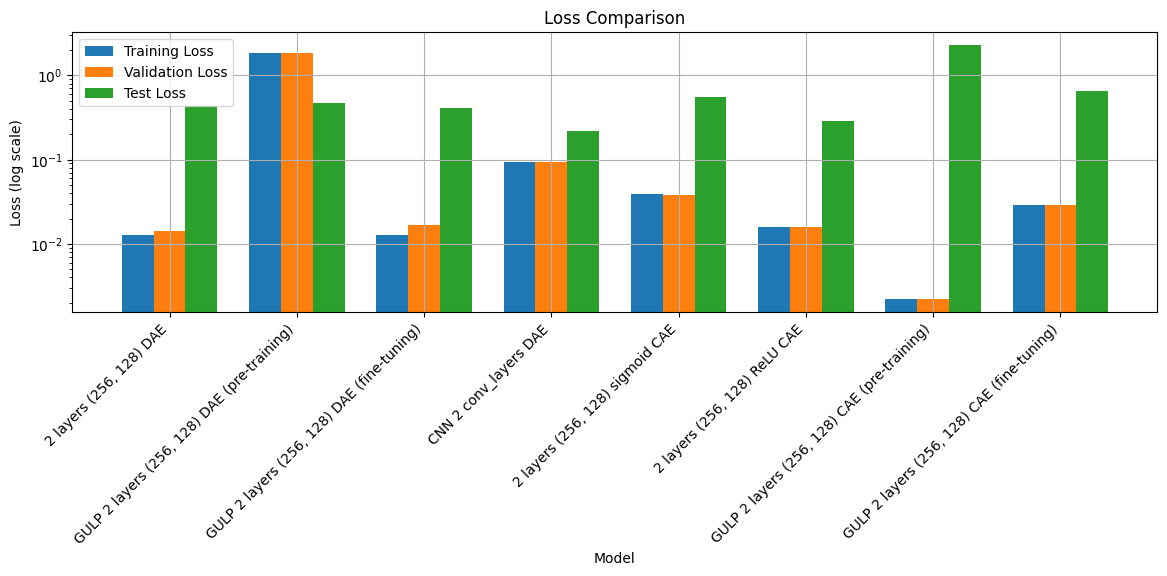

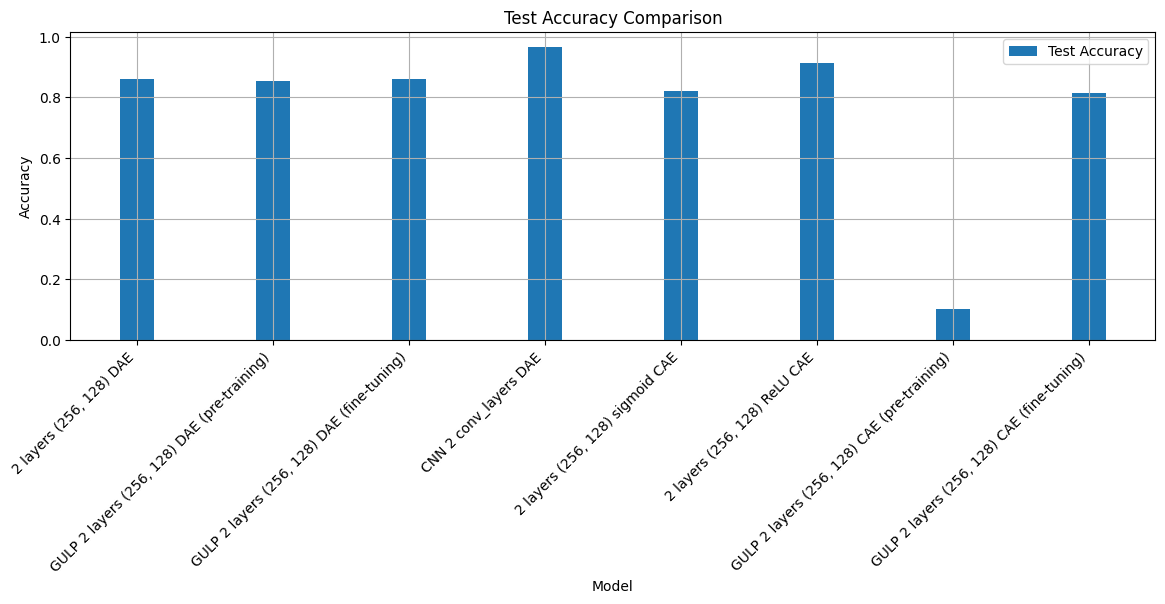

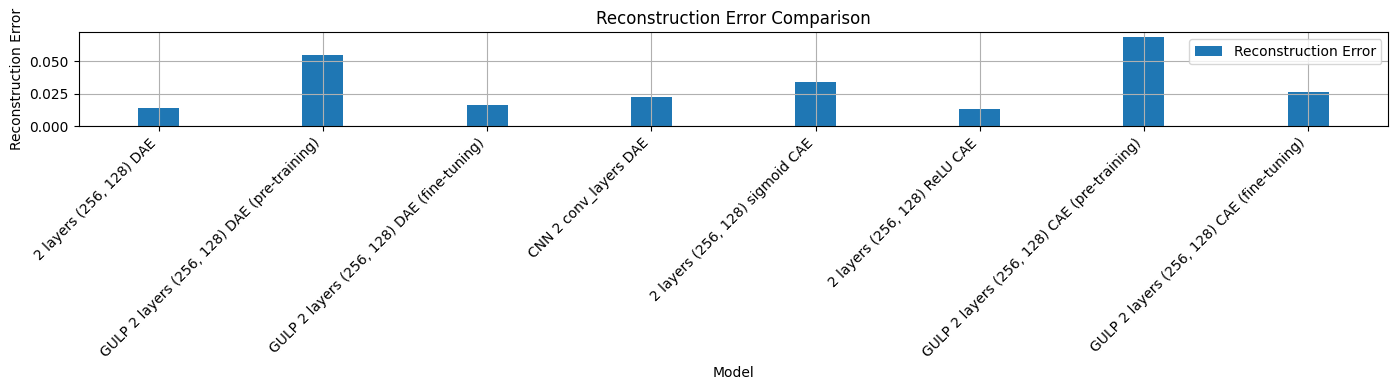

In [60]:
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
bar_width = 0.25
index = range(len(df_result))

# loss comparison
plt.bar(index, df_result['Training Loss'], bar_width, label='Training Loss')
plt.bar([i + bar_width for i in index], df_result['Validation Loss'], bar_width, label='Validation Loss')
plt.bar([i + 2 * bar_width for i in index], df_result['Test Loss'], bar_width, label='Test Loss')

plt.yscale('log')
plt.xlabel('Model')
plt.ylabel('Loss (log scale)')
plt.title('Loss Comparison')
plt.xticks([i + bar_width for i in index], df_result['Model'], rotation=45, ha='right')
plt.legend()
plt.grid(True)

# test accuracy
plt.figure(figsize=(14, 4))
plt.bar(index, df_result['Test Accuracy'], bar_width, label='Test Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')
plt.xticks(index, df_result['Model'], rotation=45, ha='right')
plt.legend()
plt.grid(True)

# reconstruction error
plt.figure(figsize=(14, 4))
plt.bar(index, df_result['Reconstruction Error'], bar_width, label='Reconstruction Error')
plt.xlabel('Model')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Comparison')
plt.xticks(index, df_result['Model'], rotation=45, ha='right')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()